In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
path = "/content/drive/MyDrive/Officiel/"
images = sorted(glob(os.path.join(path, "final_test_set/*")))
masks = sorted(glob(os.path.join(path, "final_masks_test/*")))
images = images[282:]
masks = masks[282:]
print(images[0])
print(masks[0])
print(len(masks))
print(len(images))

/content/drive/MyDrive/Officiel/final_test_set/Mass-Test_P_00016_LEFT_CC.jpg
/content/drive/MyDrive/Officiel/final_masks_test/Mass-Test_P_00016_LEFT_CC.jpg
361
361


In [5]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [6]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [7]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [8]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Officiel/breast_cancer_mass_VGG19.hdf5', compile = False)

In [9]:
LR = 1e-4
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [10]:
IMAGE_SIZE = 512
EPOCHS = 120
BATCH = 8
test_dataset = tf_dataset(images, masks, batch=BATCH)

test_steps = (len(images)//BATCH)
if len(images) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

46/46 [==============================] - 368s 7s/step - loss: 0.5172 - dice_coef: 0.4737 - recall: 0.3531 - precision: 0.7201


[0.5171620845794678, 0.4736621677875519, 0.3530678451061249, 0.720058023929596]

In [11]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [12]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

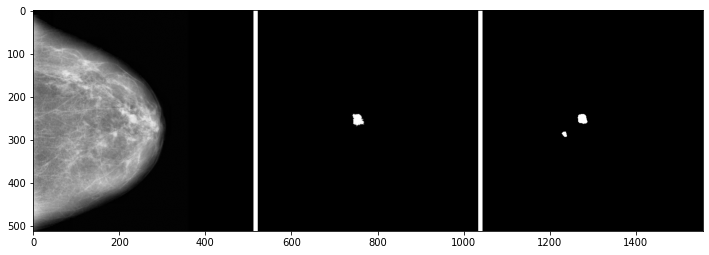

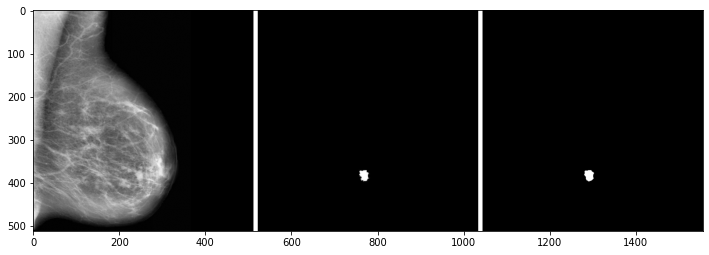

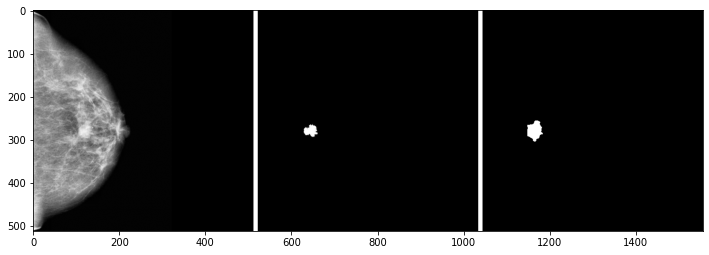

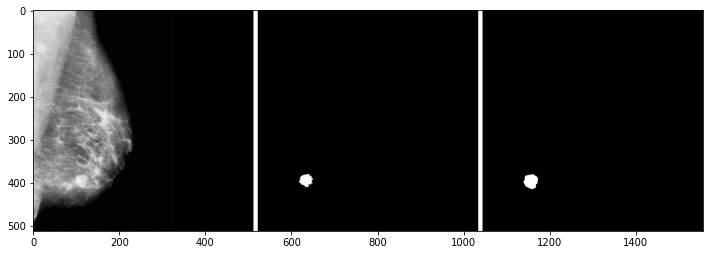

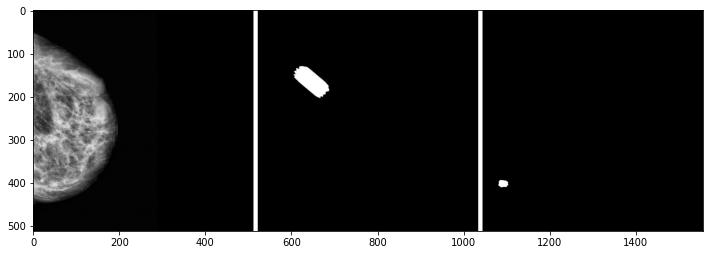

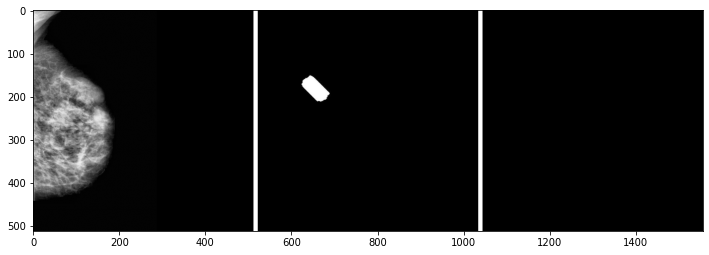

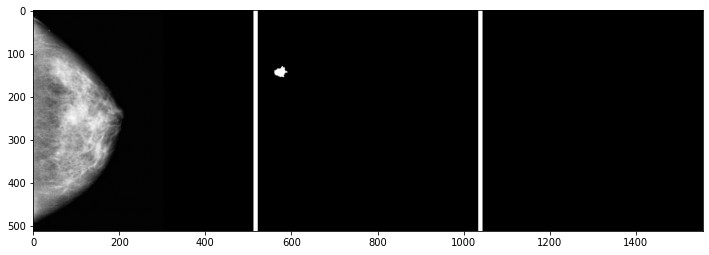

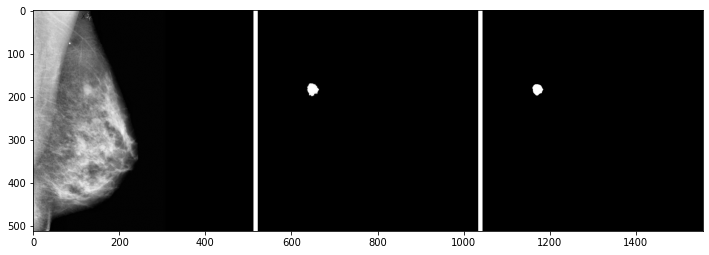

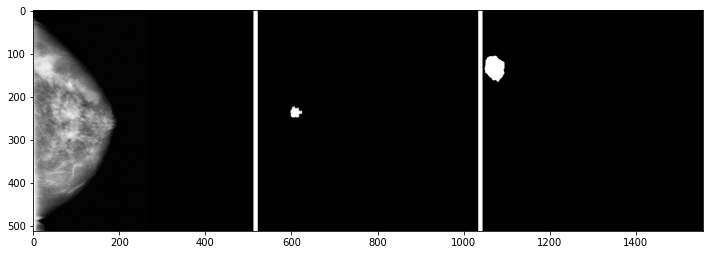

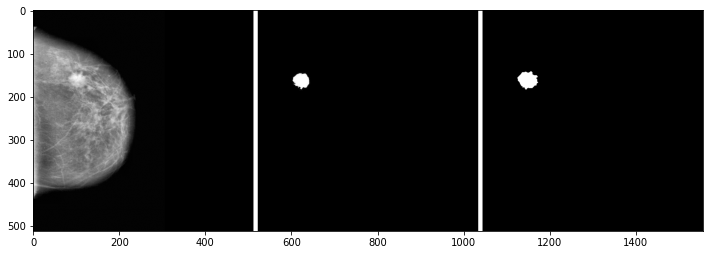

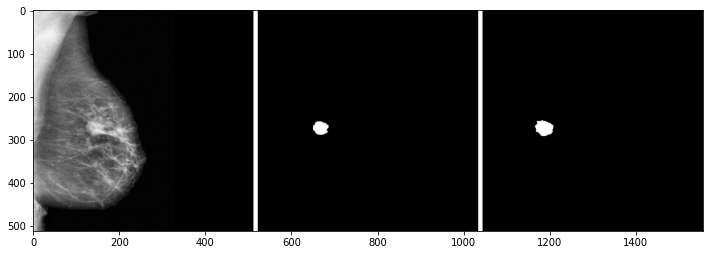

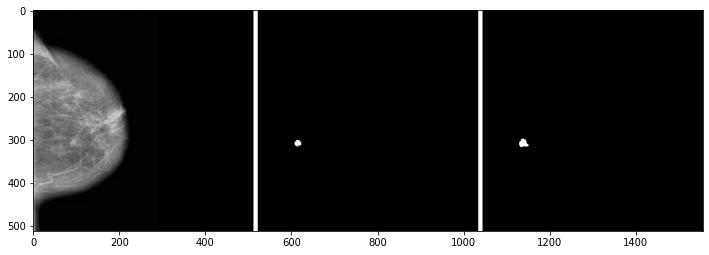

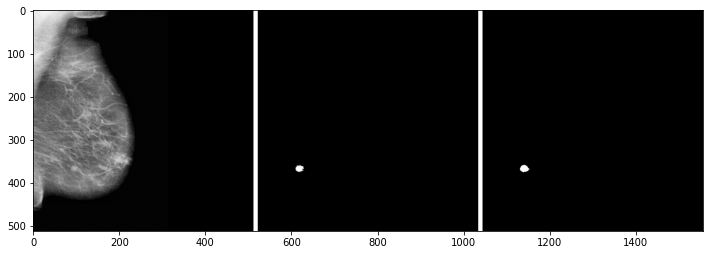

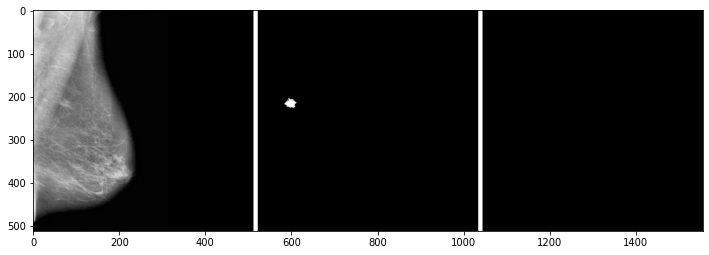

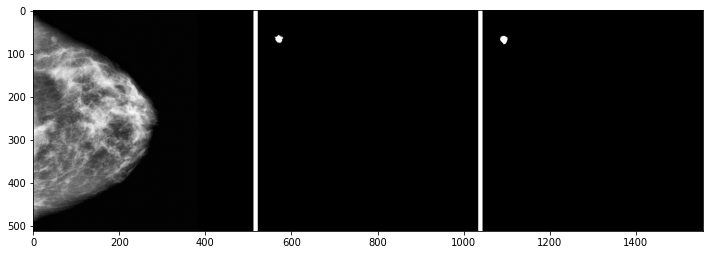

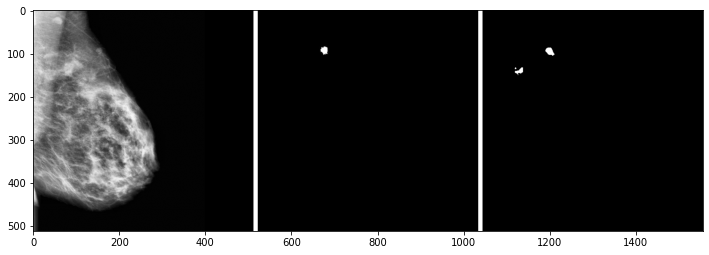

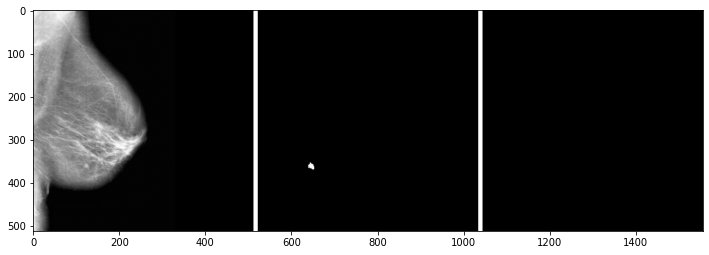

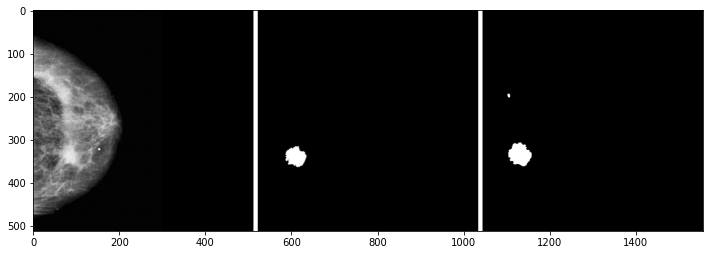

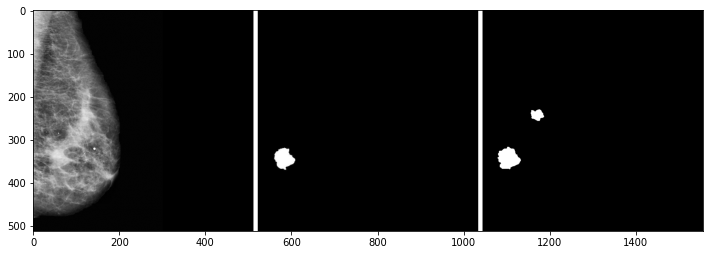

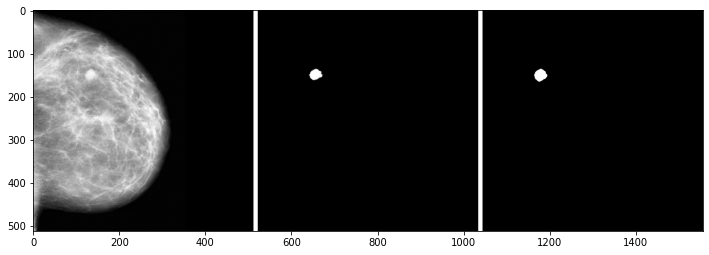

In [16]:
for i, (x, y) in enumerate(zip(images[100:120], masks[100:120])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

In [14]:
iou=[]
for i, (x, y) in enumerate(zip(images, masks)):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    intersection = np.logical_and(y, y_pred)
    union = np.logical_or(y, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    iou.append(iou_score)
    #print("IoU socre is: ", iou_score)

np.mean(iou)

0.2908416386722768